In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.io import wavfile
from pydub import AudioSegment
import os
from matplotlib.pyplot import *

%matplotlib inline

In [2]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
df = pd.read_feather('vocalization_df.feather')

df_c2 = df[df.cohort=='c2']
df_c4 = df[df.cohort=='c4']
df_c5 = df[df.cohort=='c5']

c2_umap = np.vstack(df_c2.latent_mean_umap.values)
c4_umap = np.vstack(df_c4.latent_mean_umap.values)
c5_umap = np.vstack(df_c5.latent_mean_umap.values)

all_umap = np.vstack(df.latent_mean_umap.values)

outline = np.load('/Users/rep359/Downloads/umap_outline_c245.npy')

# probability densities

In [4]:
_bins = 50
c2_heatmap = np.rot90(np.histogram2d(c2_umap[:,0], c2_umap[:,1], bins=_bins)[0]/np.histogram2d(c2_umap[:,0], c2_umap[:,1], bins=_bins)[0].sum())*100
c4_heatmap = np.rot90(np.histogram2d(c4_umap[:,0], c4_umap[:,1], bins=_bins)[0]/np.histogram2d(c4_umap[:,0], c4_umap[:,1], bins=_bins)[0].sum())*100
c5_heatmap = np.rot90(np.histogram2d(c5_umap[:,0], c5_umap[:,1], bins=_bins)[0]/np.histogram2d(c5_umap[:,0], c5_umap[:,1], bins=_bins)[0].sum())*100

all_heatmap = np.rot90(np.histogram2d(all_umap[:,0], all_umap[:,1], bins=_bins)[0]/np.histogram2d(all_umap[:,0], all_umap[:,1], bins=_bins)[0].sum())*100

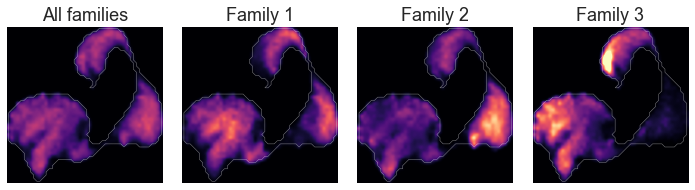

In [5]:
figure(figsize=(10,4))

width = 0.5
_alpha = 0.5
_clim = (0, 0.35)

subplot(1,4,1)
imshow(all_heatmap, clim=_clim, interpolation='gaussian', cmap='magma')
plot(outline[:,0], -outline[:,1], 'w', linewidth=width, alpha=_alpha)
axis('off')
title('All families')

subplot(1,4,2)
imshow(c2_heatmap, clim=_clim, interpolation='gaussian', cmap='magma')
plot(outline[:,0], -outline[:,1], 'w', linewidth=width, alpha=_alpha)
axis('off')
title('Family 1')

subplot(1,4,3)
imshow(c4_heatmap, clim=_clim, interpolation='gaussian', cmap='magma')
plot(outline[:,0], -outline[:,1], 'w', linewidth=width, alpha=_alpha)
axis('off')
title('Family 2')

subplot(1,4,4)
imshow(c5_heatmap, clim=_clim, interpolation='gaussian', cmap='magma')
plot(outline[:,0], -outline[:,1], 'w', linewidth=width, alpha=_alpha)
axis('off')
title('Family 3')

tight_layout()

# savefig('/Users/ralph/Downloads/family_umap.svg', dpi=300)

# cluster usages

In [6]:
z = df.groupby('z_70')['timestamp'].count().values
reorder = np.argsort(z)[::-1]


z_c2 = df_c2.groupby('z_70')['timestamp'].count().values[reorder]
z_c4 = df_c4.groupby('z_70')['timestamp'].count().values[reorder]
z_c5 = df_c5.groupby('z_70')['timestamp'].count().values[reorder]

z_c2_prop = z_c2/sum(z_c2)
z_c4_prop = z_c4/sum(z_c4)
z_c5_prop = z_c5/sum(z_c5)

z_all_prop = np.array([z_c2_prop, z_c4_prop, z_c5_prop])

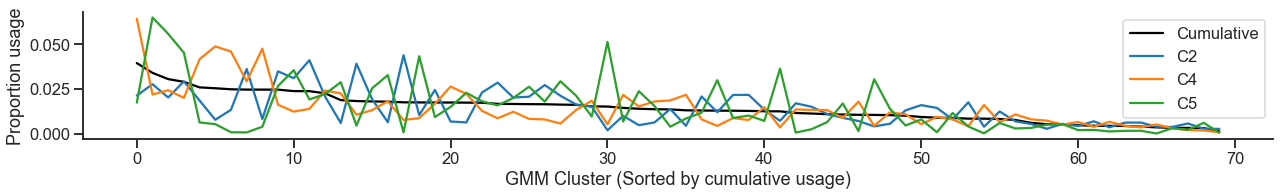

In [7]:
figure(figsize=(18,3))

plot(z[reorder]/sum(z[reorder]), 'k', label='Cumulative')
plot(z_c2_prop, label='C2')
plot(z_c4_prop, label='C4')
plot(z_c5_prop, label='C5')

ylabel('Proportion usage')
xlabel('GMM Cluster (Sorted by cumulative usage)')

legend(bbox_to_anchor=(1,1))
sns.despine()
tight_layout()
# savefig('/Users/ralph/Downloads/gmm_usage.svg')

# difference plots

In [8]:
z2z4_diff = np.argsort(z_c2_prop-z_c4_prop)
z2z5_diff = np.argsort(z_c2_prop-z_c5_prop)
z4z5_diff = np.argsort(z_c4_prop-z_c5_prop)

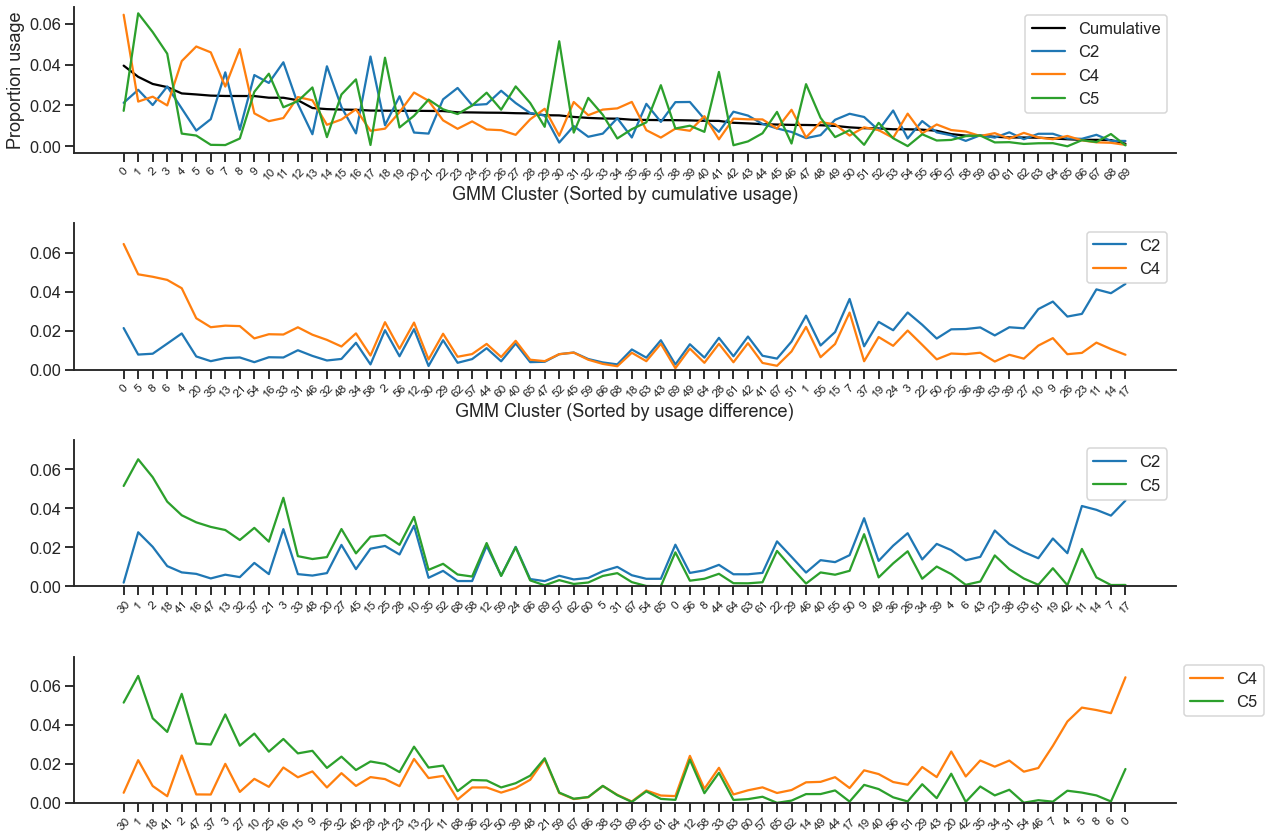

In [9]:
figure(figsize=(18,12))

_fontsize=12

subplot(4,1,1)
plot(z[reorder]/sum(z[reorder]), 'k', label='Cumulative')
plot(z_c2_prop, label='C2')
plot(z_c4_prop, label='C4')
plot(z_c5_prop, label='C5')

ylabel('Proportion usage')
xlabel('GMM Cluster (Sorted by cumulative usage)')
xticks(np.arange(70), fontsize=_fontsize, rotation=45)
legend(bbox_to_anchor=(1,1))
sns.despine()


subplot(4,1,2)
plot(z_c2_prop[z2z4_diff], label='C2', c='C0')
plot(z_c4_prop[z2z4_diff], label='C4', c='C1')
legend(bbox_to_anchor=(1,1))
xticks(np.arange(70), z2z4_diff, rotation=45, fontsize=_fontsize)
ylim(0,.075)
# ylabel('Proportion usage')
xlabel('GMM Cluster (Sorted by usage difference)')

subplot(4,1,3)
plot(z_c2_prop[z2z5_diff], label='C2', c='C0')
plot(z_c5_prop[z2z5_diff], label='C5', c='C2')
legend(bbox_to_anchor=(1,1))
xticks(np.arange(70), z2z5_diff, rotation=45, fontsize=_fontsize)
ylim(0,.075)

subplot(4,1,4)
plot(z_c4_prop[z4z5_diff], label='C4', c='C1')
plot(z_c5_prop[z4z5_diff], label='C5', c='C2')
legend(bbox_to_anchor=(1,1))
xticks(np.arange(70), z4z5_diff, rotation=45, fontsize=_fontsize)
ylim(0,.075)

sns.despine()
tight_layout()
# savefig('usages.svg')

# top over-expressed cluster examples

In [10]:
n=5

c2_top = np.concatenate((z2z4_diff[-n:], z2z5_diff[-n:]))
c4_top = np.concatenate((z2z4_diff[:n], z4z5_diff[-n:]))
c5_top = np.concatenate((z2z5_diff[:n], z4z5_diff[:n]))

len(np.unique(c2_top)), len(np.unique(c4_top)), len(np.unique(c5_top))

(7, 5, 5)

In [11]:
np.unique(c2_top)

array([ 7, 11, 14, 17, 23, 26, 42], dtype=int64)

In [12]:
np.unique(c4_top)

array([0, 4, 5, 6, 8], dtype=int64)

In [13]:
np.unique(c5_top)

array([ 1,  2, 18, 30, 41], dtype=int64)

In [14]:
b = [7, 9, 11, 14, 17]
o = [0, 4, 5, 6, 8]
g = [1, 2, 3, 18, 30]

states_reorder = b+o+g
states = [np.where(reorder == states_reorder[i])[0][0] for i in range(len(states_reorder))]

border_positions = np.array([[0,0],
                             [0,1],
                             [0,2],
                             [0,3],
                             [0,4],
                             [1,0],
                             [1,1],
                             [1,2],
                             [1,3],
                             [1,4],
                             [2,0],
                             [2,1],
                             [2,2],
                             [2,3],
                             [2,4]])

indicies_flat = [0]*len(states)

In [15]:
example_idx = []

for i in range(len(states)):
    n_samples = 100
    df_sub = df_c2[df_c2.z_70 == states[i]]
    prob_z_70 = np.array([df_sub['prob_z_70'].values[j][states[i]] for j in range(len(df_sub))])
    sortby_prob = np.argsort(prob_z_70)[::-1]
    df_sub = df_sub.iloc[sortby_prob[:n_samples]]
    
    example_idx.append(df_sub.index[indicies_flat[i]])
    
df_example = df_c2.iloc[example_idx]

0


C:\Users\rep359\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


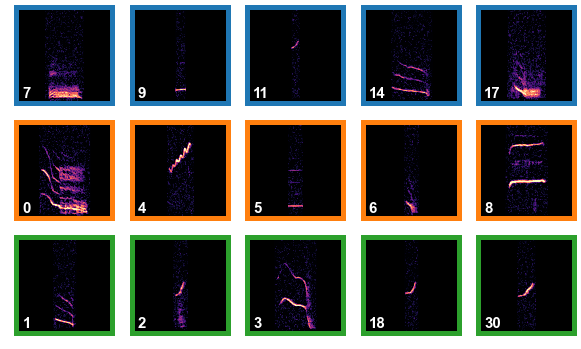

In [16]:
audio_basename = 'cohort2_combined_audio/'
fs=125000

fig = figure(figsize=(10,6))
gs = fig.add_gridspec(3,5)

colors = ['C0','C0','C0','C0','C0',
          'C1','C1','C1','C1','C1',
          'C2','C2','C2','C2','C2']


for i in range(len(border_positions)):
    print(i)
    
    working_onset, working_offset = df_example.onset.values[i], df_example.offset.values[i]
    working_filename = df_example.audio_filename.values[i]

    working_audio_slice = AudioSegment.from_file(os.path.join(audio_basename, working_filename), 
                                         codec='pcm_f64le', 
                                         start_second=working_onset, 
                                         duration=working_offset-working_onset)

    working_audio = np.array(working_audio_slice.get_array_of_samples())

    v = np.zeros(int(.3*fs))
    v[int((len(v)/2) - len(working_audio)/2):int((len(v)/2) +len(working_audio)/2)] = working_audio
#     v[v==0] = np.min(working_audio)

    ax = fig.add_subplot(gs[border_positions[i][0], border_positions[i][1]])
#     ax.imshow(img_rand)
    
    ax.set_facecolor('k')
    ax.specgram(v, NFFT=512, noverlap=256, Fs=fs,clim=(-10,20), cmap='magma')
    
    
    
    ax.set_xticks([])
    ax.set_yticks([])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_color(colors[i])
        ax.spines[axis].set_linewidth(5)
    
    ax.text(.02, 3500, str(states_reorder[i]), color='w', fontsize=15,  weight='bold')
        
# ax.axis('equal')
# ax.axis('off');
# ax.text(.1, .1, str(states[i]), color='k')

# savefig('C:/Users/rep359/Downloads/over-expressed-vox.svg')